In [1]:
import multiprocessing
import itertools
import requests
import pandas as pd
from polygon import RESTClient
import pandas as pd
from polygonAPIkey import polygonAPIkey
from pandas_datareader import data as pdr
from tqdm.auto import tqdm
import multiprocessing as mp
import numpy as np
import yfinance as yf
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

yf.pdr_override()

In [2]:
def rel_change(df, lookback_period_days, column_name):
    df[column_name + '_rel_change'] = 0
    for i in range(lookback_period_days, len(df)):
        historical = df.iloc[i-lookback_period_days:i][column_name]
        today = df.iloc[i][column_name]
        df.loc[df.index[i], column_name + '_rel_change'] = (today - historical.mean()) / historical.mean()
    return df

def feature_gen(tick):
    prices = pdr.get_data_yahoo(tick)
    prices['Adj High'] = prices['High'] * prices['Adj Close'] / prices['Close']
    prices['Adj Low'] = prices['Low'] * prices['Adj Close'] / prices['Close']
    prices['Adj Open'] = prices['Open'] * prices['Adj Close'] / prices['Close']


    # Assuming 'prices' is a DataFrame
    prices = rel_change(prices, 5, 'Volume')
    prices = rel_change(prices, 5, 'Adj High')
    prices = rel_change(prices, 5, 'Adj Low')

    prices = prices[5:]
    # Averaging high change and low change, so capture volatility
    prices['Avg_rel_change'] = (prices['Adj High_rel_change'] - prices['Adj Low_rel_change']) / 2
    
    data = prices.loc[:, ['Adj Close', 'Volume', 'Volume_rel_change', 'Avg_rel_change']]
    data['transaction amount'] = data['Adj Close'] * data['Volume']
    # Y is next day adjusted close price relative change
    data['pct_ret'] = data['Adj Close'].pct_change()
    data['pct_ret'] = data['pct_ret'].shift(-1)
    
    #filter out only tradable days
    data = data[(data['Volume'] > 4000000) & (data['Adj Close'] > 5) & (data['transaction amount'] > 40000000)]
    

    data = data[['Volume_rel_change', 'Avg_rel_change', 'pct_ret']]

    data.dropna(inplace=True)
    return data


In [ ]:
# 积攒所有的股票
# 要backtest for every single stock to get ful list of stocks
# plot the graph


df = pd.DataFrame(columns=['Volume_rel_change', 'Avg_rel_change', 'pct_ret'])
tickers = pd.read_csv('tickers.csv')
for tick in tqdm(tickers['ticker']):
    res = feature_gen(tick)
    df = df.append(res, ignore_index=True)

df.to_csv('dataset.csv')



In [9]:
prices = pd.read_csv('dataset.csv', index_col=0)
prices.head()


,Volume_rel_change,Avg_rel_change,pct_ret
0,5.074888,0.001665,0.001479
1,5.917972,0.000996,-0.005284
2,9.849002,-0.000312,0.002328
3,4.998489,0.000983,-0.007289
4,4.387466,0.002535,0.002824


In [4]:
(prices['Volume_rel_change'] > 10).mean()

0.003320898296162231

In [5]:
((prices['Avg_rel_change'] < -1 ) | (prices['Avg_rel_change'] > 1)).mean()

4.096128551684798e-05

In [21]:
# outliers removal
prices = prices[(prices['Volume_rel_change'] < 10) & ((prices['Avg_rel_change'] > -1) & (prices['Avg_rel_change'] < 1))]
prices.__len__()

1313929

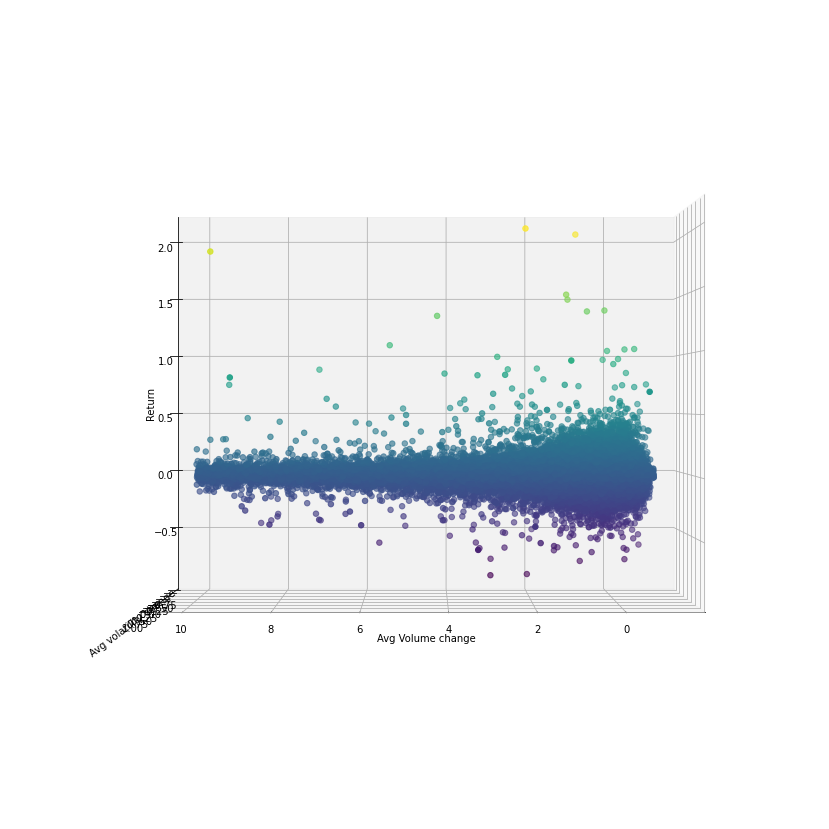

In [23]:
# plot a 3d graph where x and y are features, z is the target

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# read data
data = prices
X = data.iloc[:, 0:2]
y = data.iloc[:, 2]

# plot
fig = plt.figure(figsize=(25, 15))
ax = plt.axes(projection='3d')
# increase dot size
ax.scatter3D(X.iloc[:, 0], X.iloc[:, 1], y, c=y, cmap='viridis', s=30)

ax.set_xlabel('Avg Volume change')
ax.set_ylabel('Avg volatility change')
ax.set_zlabel('Return')
# set range of x1 and x2 to (-3,3), (-2,2)   

ax.view_init(0, 90)
plt.show()




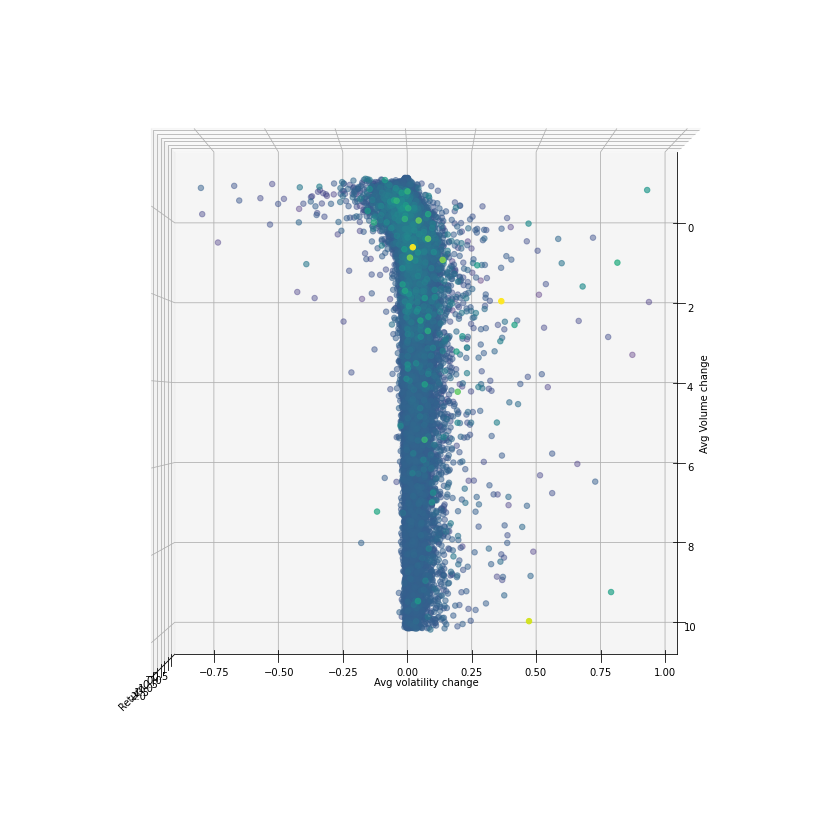

In [24]:
# plot another same graph but with different view
fig = plt.figure(figsize=(25, 15))
ax = plt.axes(projection='3d')
# increase dot size
ax.scatter3D(X.iloc[:, 0], X.iloc[:, 1], y, c=y, cmap='viridis', s=30)

ax.set_xlabel('Avg Volume change')
ax.set_ylabel('Avg volatility change')
ax.set_zlabel('Return')
# set range of x1 and x2 to (-3,3), (-2,2)   

ax.view_init(90, 0)
plt.show()

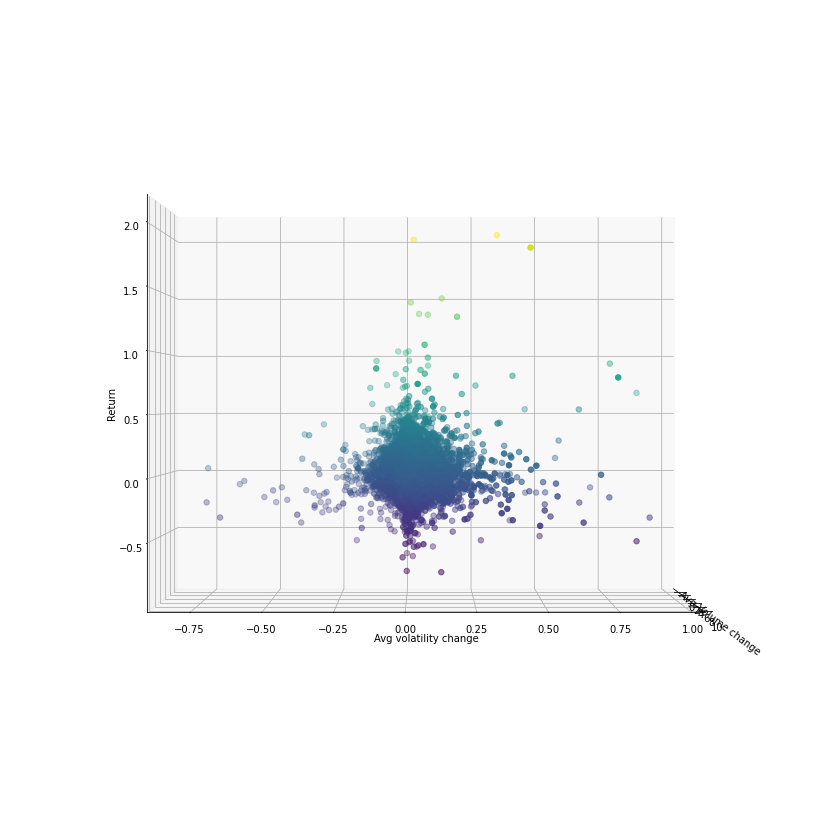

In [25]:
 # plot another same graph but with different view
fig = plt.figure(figsize=(25, 15))
ax = plt.axes(projection='3d')
# increase dot size
ax.scatter3D(X.iloc[:, 0], X.iloc[:, 1], y, c=y, cmap='viridis', s=30)

ax.set_xlabel('Avg Volume change')
ax.set_ylabel('Avg volatility change')
ax.set_zlabel('Return')
# set range of x1 and x2 to (-3,3), (-2,2)   

ax.view_init(0, 0)
plt.show()